# The Autocoder for music recommendtion system

In [45]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import os
import torch
import torch.nn as nn
import tensorflow as tf
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.model_selection import train_test_split
from datasets import Dataset, DatasetDict, load_dataset
from typing import Literal
from tensorflow.keras.layers import Input, Dense
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

In [2]:
music_dataset = load_dataset("yandex/yambda", "flat-50m", streaming=True)

In [3]:
class YambdaDataset:
    INTERACTIONS = frozenset([
        "likes", "listens", "multi_event", "dislikes", "unlikes", "undislikes"
    ])

    def __init__(
        self,
        dataset_type: Literal["flat", "sequential"] = "flat",
        dataset_size: Literal["50m", "500m", "5b"] = "50m"
    ):
        self.dataset_type = dataset_type
        self.dataset_size = dataset_size

    def interaction(self, event_type: Literal[
        "likes", "listens", "multi_event", "dislikes", "unlikes", "undislikes"
    ]) -> Dataset:
        return self._download(f"{self.dataset_type}/{self.dataset_size}", f"{event_type}.parquet")

    def audio_embeddings(self) -> Dataset:
        return self._download("", "embeddings.parquet")

    def album_item_mapping(self) -> Dataset:
        return self._download("", "album_item_mapping.parquet")

    def artist_item_mapping(self) -> Dataset:
        return self._download("", "artist_item_mapping.parquet")

    def genre_item_mapping(self) -> Dataset:
        return self._download("", "genre_item_mapping.parquet")

    def user_item_mapping(self) -> Dataset:
        return self._download("", "user_item_mapping.parquet")

    @staticmethod
    def _download(data_dir: str, file: str) -> Dataset:
        data = load_dataset("yandex/yambda", data_dir=data_dir, data_files=file)
        return data["train"]



In [4]:
# Инициализация загрузчика
dataset = YambdaDataset("flat", "50m")

listens_ds = dataset.interaction("listens").to_pandas()
likes_ds = dataset.interaction("likes").to_pandas()
dislikes_ds = dataset.interaction("dislikes").to_pandas()
unlikes_ds = dataset.interaction("unlikes").to_pandas()
undislikes_ds = dataset.interaction("undislikes").to_pandas()
# embeddings_ds = dataset.audio_embeddings()

In [5]:
# Вывод шапок
print(listens_ds.head())
print(likes_ds.head())
print(dislikes_ds.head())
print(unlikes_ds.head())
print(undislikes_ds.head())

   uid  timestamp  item_id  is_organic  played_ratio_pct  track_length_seconds
0  100      39420  8326270           0               100                   170
1  100      39420  1441281           0               100                   105
2  100      39625   286361           0               100                   185
3  100      40110   732449           0               100                   240
4  100      40360  3397170           0                46                   130
   uid  timestamp  item_id  is_organic
0  100      44755   732449           1
1  100    1155860  6568592           0
2  100    1259125  5411243           1
3  100    1260005  7371186           0
4  100    1263935  4943655           0
   uid  timestamp  item_id  is_organic
0  100    3087560  9170134           1
1  100    3936560  8661238           1
2  100   20432825  4927727           1
3  400    2980800   399811           1
4  400    3157520  1575108           1
   uid  timestamp  item_id  is_organic
0  100    3087555  

In [6]:
# Создаём  таблицу только с нужными колонками и флагом
listens = listens_ds[['uid', 'item_id', 'played_ratio_pct']].copy()

likes = likes_ds[['uid', 'item_id']].copy()
likes['liked'] = True

dislikes = dislikes_ds[['uid', 'item_id']].copy()
dislikes['disliked'] = True

In [7]:
listens = listens.merge(
    likes,
    on=['uid', 'item_id'],
    how='left'
)

listens['liked'] = listens['liked'].fillna(False)

listens = listens.merge(
    dislikes,
    on=['uid', 'item_id'],
    how='left'
)

listens['disliked'] = listens['disliked'].fillna(False)

print(listens.head())

   uid  item_id  played_ratio_pct  liked  disliked
0  100  8326270               100  False     False
1  100  1441281               100  False     False
2  100   286361               100  False     False
3  100   732449               100   True     False
4  100  3397170                46  False     False


In [8]:
# Calculate total number of elements in the table
total_elements = listens.size

# Count zero or empty values
zero_or_empty_count = (listens == 0).sum().sum() + listens.isnull().sum().sum()

# Calculate sparsity
sparsity = zero_or_empty_count / total_elements

print(f"Sparsity of the listens table: {sparsity:.4f}")

Sparsity of the listens table: 0.3676


In [9]:
# Calculate standard sparsity: proportion of zero or empty values to total elements
# For boolean columns, False is considered sparse
num_elements = listens.size
num_sparse_elements = (listens == False).sum().sum() + listens.isnull().sum().sum()
standard_sparsity = num_sparse_elements / num_elements

# Calculate logical sparsity: rows where both liked and disliked are False
logical_sparse_rows = listens[(listens['liked'] == False) & (listens['disliked'] == False) & (listens['played_ratio_pct'] < 70)]
logical_sparsity = len(logical_sparse_rows) / len(listens)

print(f"Standard Sparsity: {standard_sparsity:.2f}")
print(f"Logical Sparsity: {logical_sparsity:.2f}")


Standard Sparsity: 0.37
Logical Sparsity: 0.30


In [10]:
# Create interaction column
listens['interaction'] = listens['liked'] * 1 + listens['disliked'] * -1

# Drop liked and disliked columns
listens = listens.drop(columns=['liked', 'disliked'])

# Display the transformed DataFrame
print(listens)

              uid  item_id  played_ratio_pct  interaction
0             100  8326270               100            0
1             100  1441281               100            0
2             100   286361               100            0
3             100   732449               100            1
4             100  3397170                46            0
...           ...      ...               ...          ...
47166555  1000000  3369589                99            0
47166556  1000000  8120372                99            0
47166557  1000000  1578810                99            0
47166558  1000000  3732104               100            0
47166559  1000000  2978154                74            0

[47166560 rows x 4 columns]


In [11]:
encoder = LabelEncoder()
listens['uid_enc'] = encoder.fit_transform(listens['uid'])
listens['item_id_enc'] = encoder.fit_transform(listens['item_id'])

In [12]:
# Удаляем треки, которые слушали менее 25 раз
track_counts = listens.groupby('item_id_enc').size()
valid_tracks = track_counts[track_counts >= 25].index
listens = listens[listens['item_id_enc'].isin(valid_tracks)]

# Удаляем пользователей, которые не поставили ни одного лайка
user_likes = listens.groupby('uid')['interaction'].sum()
valid_users = user_likes[user_likes > 0].index
listens = listens[listens['uid'].isin(valid_users)]

# Display the transformed
print(listens)

              uid  item_id  played_ratio_pct  interaction  uid_enc   
0             100  8326270               100            0        0  \
1             100  1441281               100            0        0   
2             100   286361               100            0        0   
3             100   732449               100            1        0   
4             100  3397170                46            0        0   
...           ...      ...               ...          ...      ...   
47166555  1000000  3369589                99            0     9237   
47166556  1000000  8120372                99            0     9237   
47166557  1000000  1578810                99            0     9237   
47166558  1000000  3732104               100            0     9237   
47166559  1000000  2978154                74            0     9237   

          item_id_enc  
0              777983  
1              134676  
2               26814  
3               68376  
4              317373  
...            

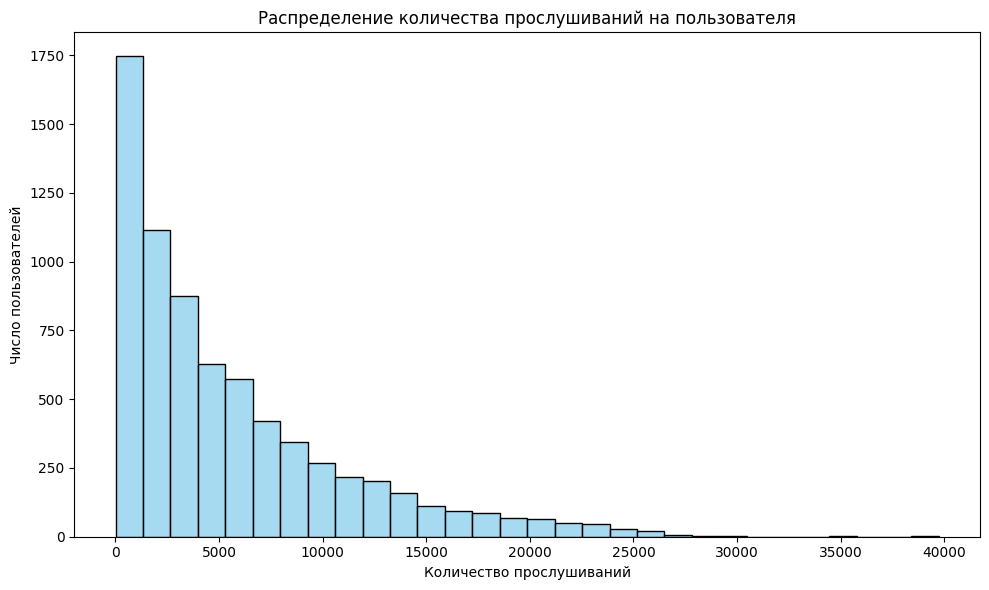

In [13]:
# Количество прослушиваний на пользователя
user_listen_counts = listens['uid_enc'].value_counts()

plt.figure(figsize=(10, 6))
sns.histplot(user_listen_counts, bins=30, color='skyblue')
plt.title('Распределение количества прослушиваний на пользователя')
plt.xlabel('Количество прослушиваний')
plt.ylabel('Число пользователей')
plt.tight_layout()
plt.show()

C:\Users\User\AppData\Local\Temp\ipykernel_18952\954607344.py:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=track_listen_counts.index[:20], y=track_listen_counts.values[:20], palette='viridis')


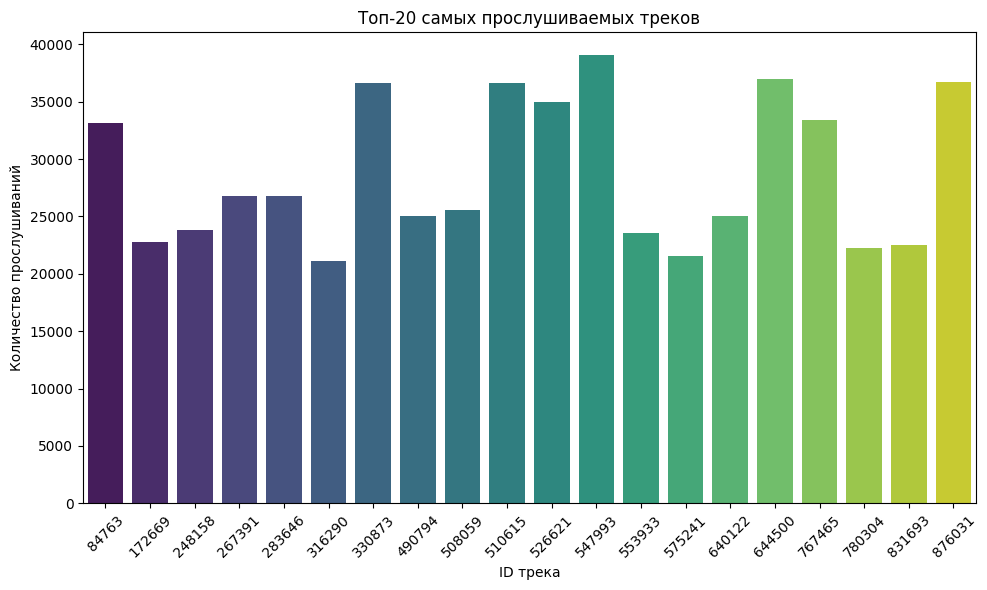

In [14]:
# Количество прослушиваний каждого трека
track_listen_counts = listens['item_id_enc'].value_counts()

plt.figure(figsize=(10, 6))
sns.barplot(x=track_listen_counts.index[:20], y=track_listen_counts.values[:20], palette='viridis')
plt.title('Топ-20 самых прослушиваемых треков')
plt.xlabel('ID трека')
plt.ylabel('Количество прослушиваний')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

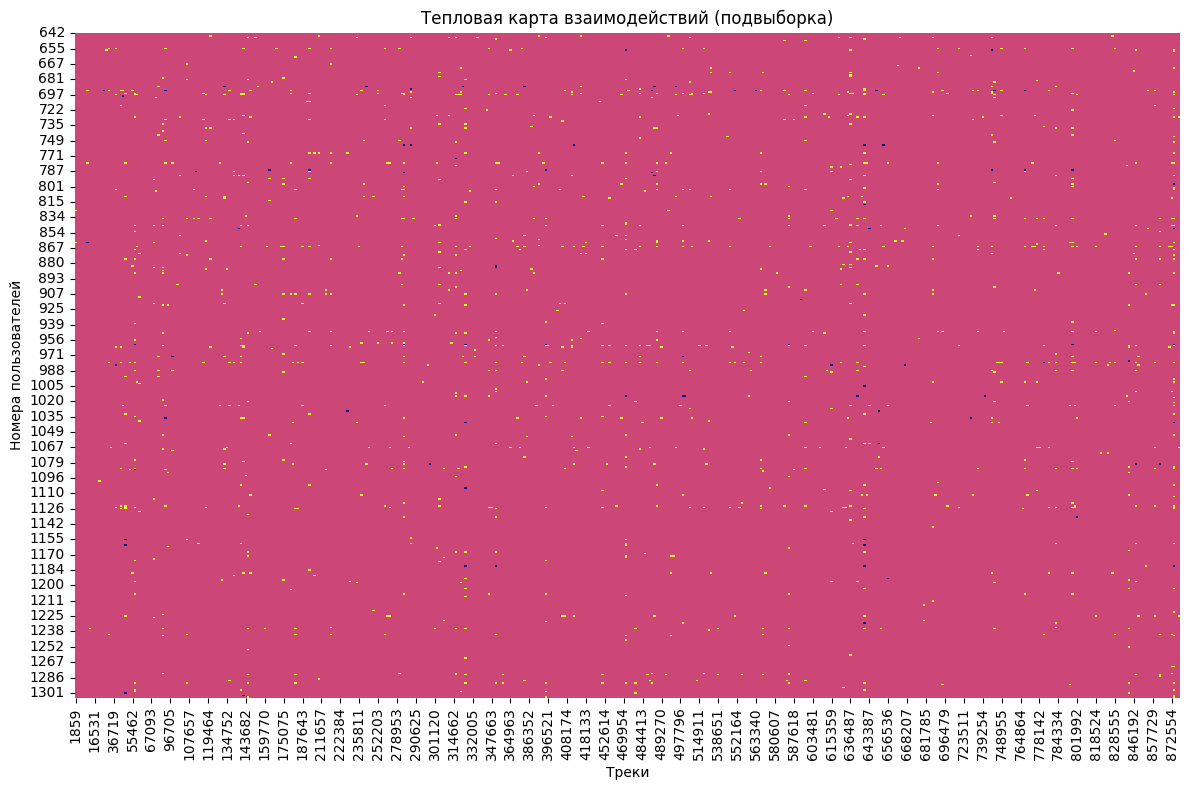

In [15]:
# Ограничим количество пользователей и треков
subset_users = listens['uid_enc'].unique()[500:1000]
subset_tracks = listens['item_id_enc'].unique()[500:1000]

# Отфильтруем таблицу
subset_df = listens[
    listens['uid_enc'].isin(subset_users) &
    listens['item_id_enc'].isin(subset_tracks)
]

# Построим матрицу взаимодействий
interaction_matrix = subset_df.pivot_table(
    index='uid_enc',
    columns='item_id_enc',
    values='interaction',
    fill_value=0
)


plt.figure(figsize=(12, 8))
sns.heatmap(interaction_matrix, cmap='plasma', cbar=False)
plt.title('Тепловая карта взаимодействий (подвыборка)')
plt.xlabel('Треки')
plt.ylabel('Номера пользователей')
plt.tight_layout()
plt.show()


In [26]:
scaler = StandardScaler()
listens_scalar = scaler.fit_transform(listens[['uid_enc', 'item_id_enc', 'played_ratio_pct', 'interaction']])

In [35]:
X = listens_scalar
# X_tensor = torch.tensor(X.values, dtype=torch.float32)

# print(X_tensor)
# print(y_tensor)

In [37]:
X_train, X_test = train_test_split(X, test_size=0.2, random_state=42)

In [38]:
input_dim = X_tensor.size(1)
latent_dim = 2

In [39]:
input_layer  = Input(shape=(input_dim,))

encoded = Dense(64, activation='relu')(input_layer)
encoded = Dense(latent_dim, activation='relu')(encoded)

decoded = Dense(64, activation='relu')(encoded)
decoded = Dense(input_dim, activation='relu')(decoded)

autoencoder = Model(inputs=input_layer, outputs=decoded)
encoder = Model(inputs=input_layer, outputs=decoded)

autoencoder.compile(optimizer='adam', loss='mse')
autoencoder.summary()

Model: "model_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 4)]               0         
                                                                 
 dense_8 (Dense)             (None, 64)                320       
                                                                 
 dense_9 (Dense)             (None, 2)                 130       
                                                                 
 dense_10 (Dense)            (None, 64)                192       
                                                                 
 dense_11 (Dense)            (None, 4)                 260       
                                                                 
Total params: 902
Trainable params: 902
Non-trainable params: 0
_________________________________________________________________


In [40]:
early_stop = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

checkpoint = ModelCheckpoint(filepath='best_autoencoder.h5', monitor='val_loss', save_best_only=True, verbose=1)

In [41]:
autoencoder.fit(X_train, X_train, epochs=30, batch_size=32, shuffle=True, validation_data=(X_test, X_test), callbacks=[early_stop, checkpoint])

Epoch 1/30
992270/992270 [==============================] - ETA: 0s - loss: 0.5528
Epoch 1: val_loss improved from inf to 0.53326, saving model to best_autoencoder.h5
992270/992270 [==============================] - 1045s 1ms/step - loss: 0.5528 - val_loss: 0.5333
Epoch 2/30
992247/992270 [============================>.] - ETA: 0s - loss: 0.5316
Epoch 2: val_loss improved from 0.53326 to 0.53202, saving model to best_autoencoder.h5
992270/992270 [==============================] - 1049s 1ms/step - loss: 0.5316 - val_loss: 0.5320
Epoch 3/30
992215/992270 [============================>.] - ETA: 0s - loss: 0.5309
Epoch 3: val_loss improved from 0.53202 to 0.53037, saving model to best_autoencoder.h5
992270/992270 [==============================] - 1046s 1ms/step - loss: 0.5309 - val_loss: 0.5304
Epoch 4/30
992252/992270 [============================>.] - ETA: 0s - loss: 0.5311
Epoch 4: val_loss did not improve from 0.53037
992270/992270 [==============================] - 1045s 1ms/step - l

In [42]:
loss = autoencoder.evaluate(X_test, X_test)
print(f"Test reconstruction loss: {loss:.4f}")

248068/248068 [==============================] - 182s 733us/step - loss: 0.5304
Test reconstruction loss: 0.5304


248068/248068 [==============================] - 181s 728us/step


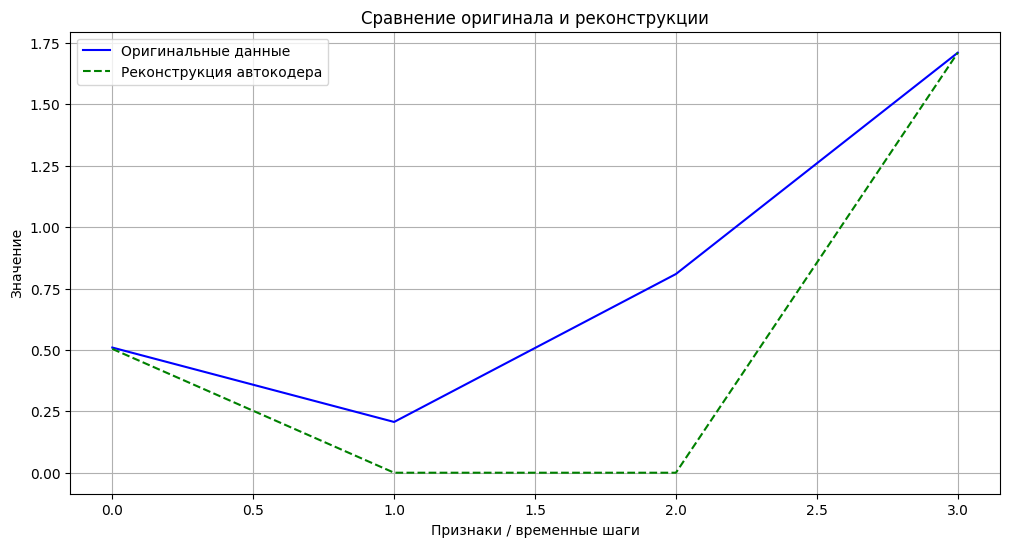

In [48]:
# Получаем реконструированные данные
X_pred = autoencoder.predict(X_test)


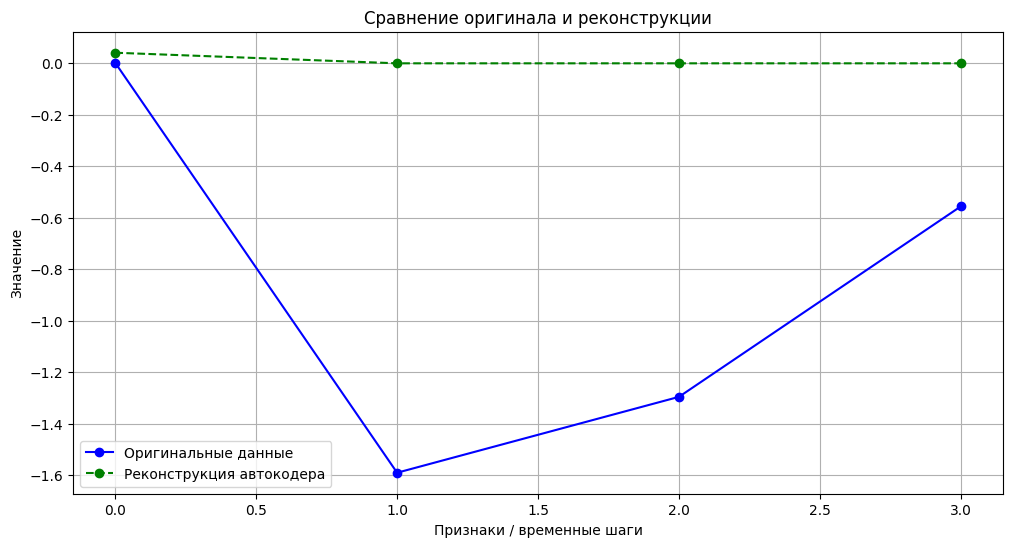

In [60]:
# Выбираем один пример для отображения
example_index = np.random.randint(0, X_test.shape[0])
original = X_test[example_index]
reconstructed = X_pred[example_index]

# Строим график
plt.figure(figsize=(12, 6))
plt.plot(original, label='Оригинальные данные', color='blue', marker="o" )
plt.plot(reconstructed, label='Реконструкция автокодера', color='green', linestyle='dashed', marker="o")
plt.title('Сравнение оригинала и реконструкции')
plt.xlabel('Признаки / временные шаги')
plt.ylabel('Значение')
plt.legend()
plt.grid(True)
plt.show()

In [54]:
# # Сохраняем модель в формате TensorFlow SavedModel
# autoencoder.save('Models/my_lstm_model')

In [47]:
# Для формата SavedModel
# autoencoder = tf.keras.models.load_model('Models/my_lstm_model')

autoencoder.summary()

Model: "model_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 4)]               0         
                                                                 
 dense_8 (Dense)             (None, 64)                320       
                                                                 
 dense_9 (Dense)             (None, 2)                 130       
                                                                 
 dense_10 (Dense)            (None, 64)                192       
                                                                 
 dense_11 (Dense)            (None, 4)                 260       
                                                                 
Total params: 902
Trainable params: 902
Non-trainable params: 0
_________________________________________________________________
